# Receipt OCR notebook series: Problem definition

> Given a arbitrary photo containing a receipt, extract grand total

![](https://storage.googleapis.com/www.forwardit.lv/kaggle/receipt_home_kaggle.png)

We will break down this problem into smaller tasks:

1. **Get a scanned version of receipt by restoring perspective**
2. Apply OCR to find all texts within image
3. Find grand total as the largest number among recognized texts

> One should remember that some tasks could be solved with traditional computer vision algorithms

This work aims to address a common pitfall among machine learning practitioners: trying to solve simple problems with the complex tools. 

# About this notebook

This is a **part one notebook** in the *Receipt OCR with OpenCV* series and will cover the first step of the process: getting a scanned version of the receipt. In order to complete this task we will:
* Locate receipt contour on the photo
* Crop image to the receipt contour
* Apply perspective restoration

Let's get started!

In [48]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image

Receipt images used in this notebook come from a tiny [personal receipt dataset](https://www.kaggle.com/dmitryyemelyanov/personal-receipt-collection). Let's check out one of them:

/var/folders/86/lg3pq2dn2fd_p6rrrc7vpzqc0000gn/T/ipykernel_90558/2654115221.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((800,800), Image.ANTIALIAS)


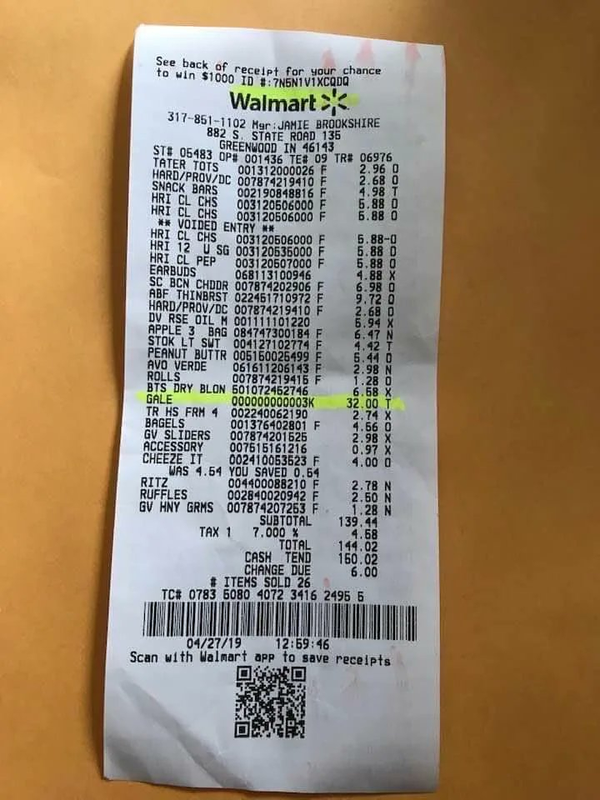

In [49]:
# Sample file out of the dataset
file_name = '/Users/ziqiangzhu/split-it/image-process/archive/images/3.jpg'
img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

# Step 1: Receipt Contour Detection
In order to find receipt contour, standart edge detection preprocessing is applied:
* Convert image to grayscale
* Aplly Gaussian filter 5x5 to get rid of noise
* Run Canny edge detector

Let's define some utility methods:

In [50]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [51]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [52]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [53]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

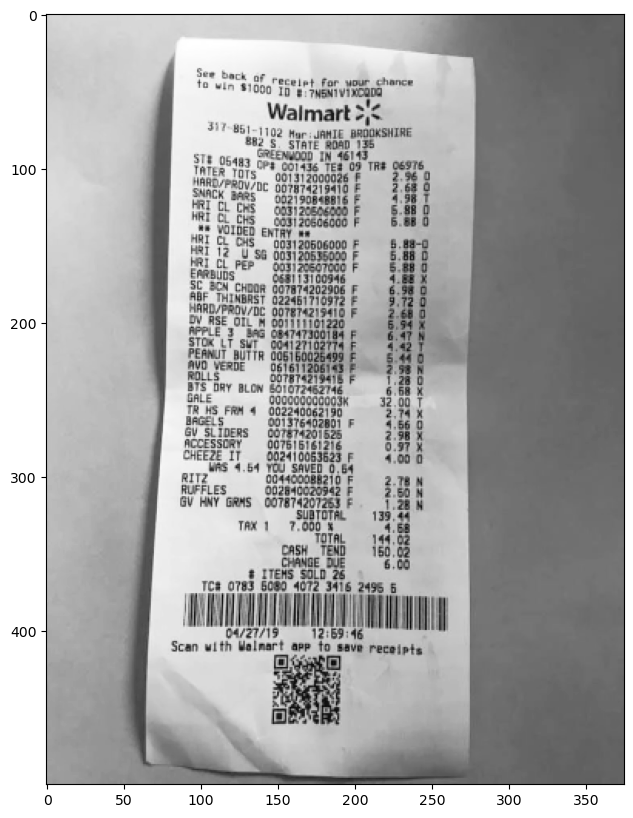

In [54]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

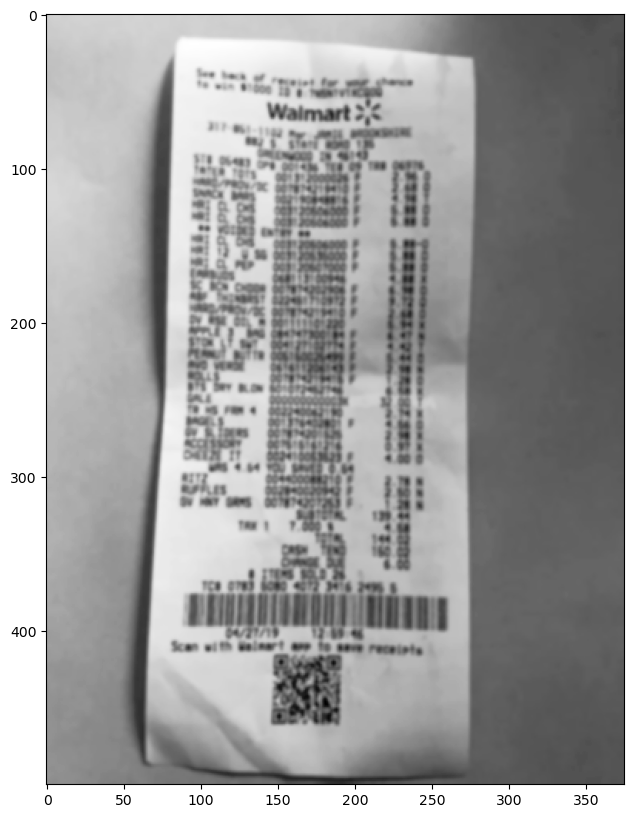

In [55]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

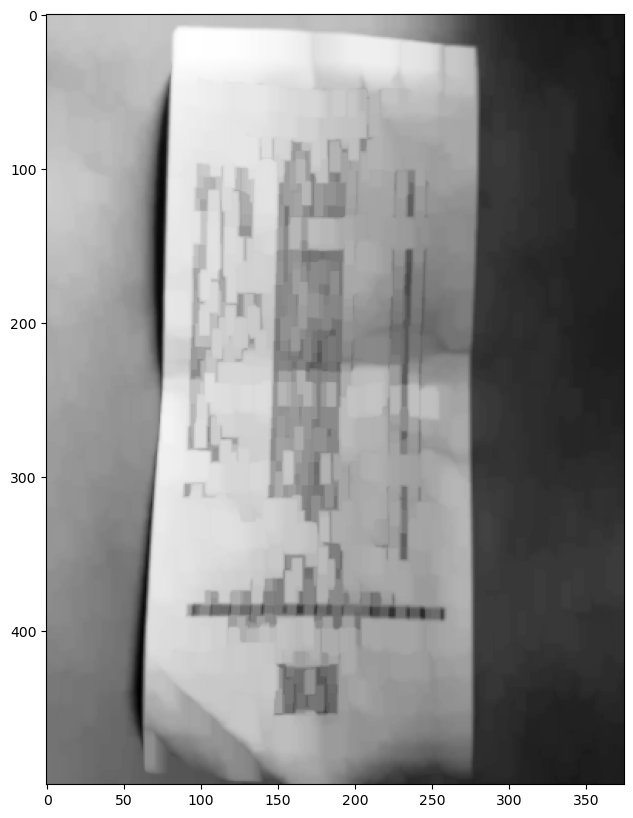

In [81]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 15))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

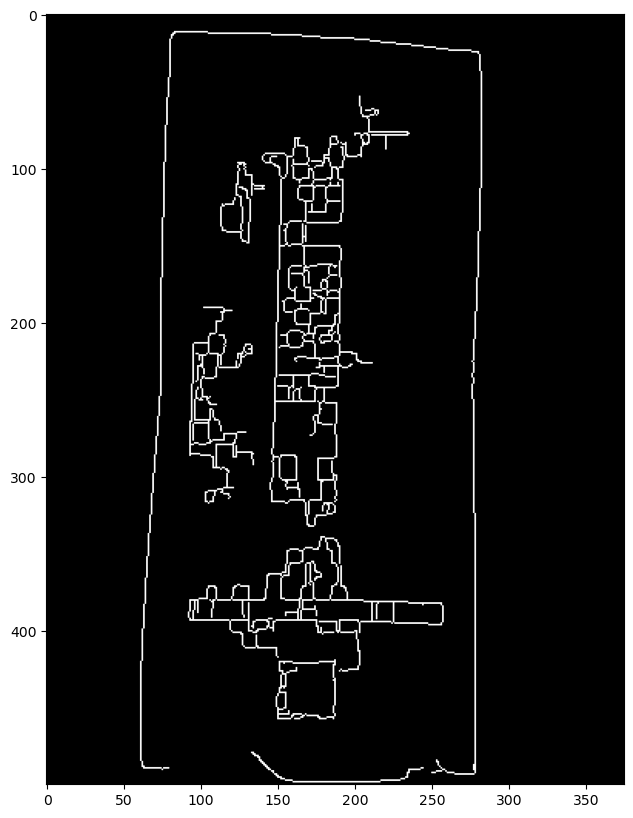

In [75]:
edged = cv2.Canny(dilated, 10, 200, apertureSize=3)
plot_gray(edged)

Edged image is a suitable input for the contour detection, which is kindly provided by OpenCV:
> Please be careful with older versions of OpenCV, as findContours works differently for versions < 3.0

In [58]:
cv2.__version__

'4.9.0'

Kaggle provides this notebook with OpenCV 4.4.0, so we are using the most recent implementation of `findContours`

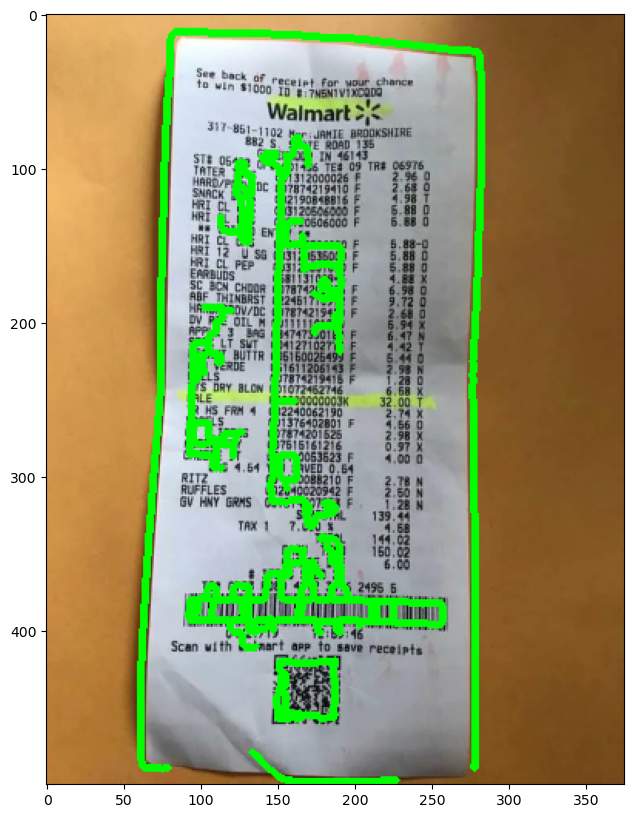

In [59]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

To find the contour of receipt we will make use of two simple heuristics: 
* receipt is the largest contour whithin image
* receipt is expected to be of a rectangular shape 

We will start with the first heuristic by getting TOP largest contours.

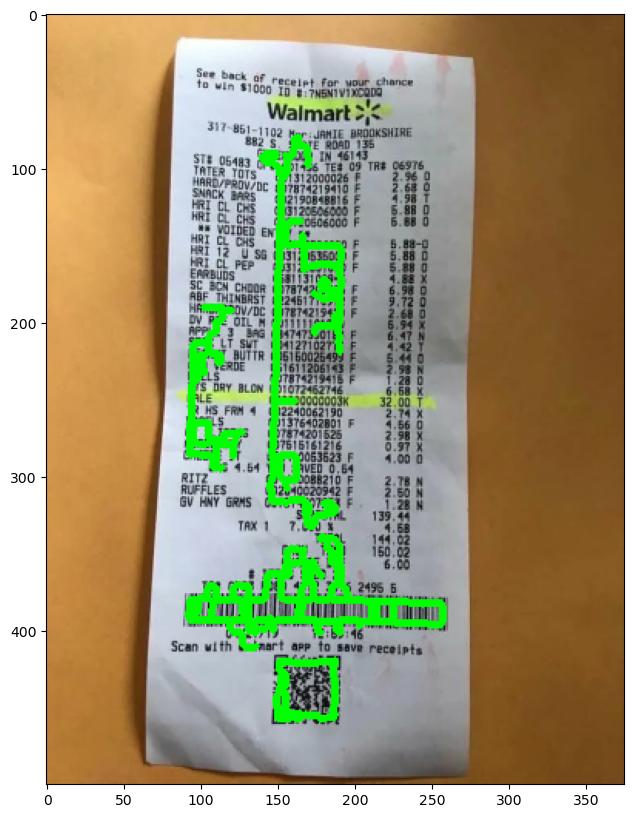

In [60]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

We will use `approxPolyDP` for approximating more primitive contour shape consisting of as few points as possible. It takes perimeter as one of the arguments, so we have to calculate it with `arcLength`. Let's define a helper method that does the approximation: 

In [61]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

This allows us to find a rectangle by looking whether the number of approximated contour points is 4:

In [62]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [63]:
get_receipt_contour(largest_contours)

array([[[187, 419]],

       [[151, 420]],

       [[150, 457]],

       [[186, 457]]], dtype=int32)

> It is also important to get down to just four contour points, as we will need them for perspective restoration

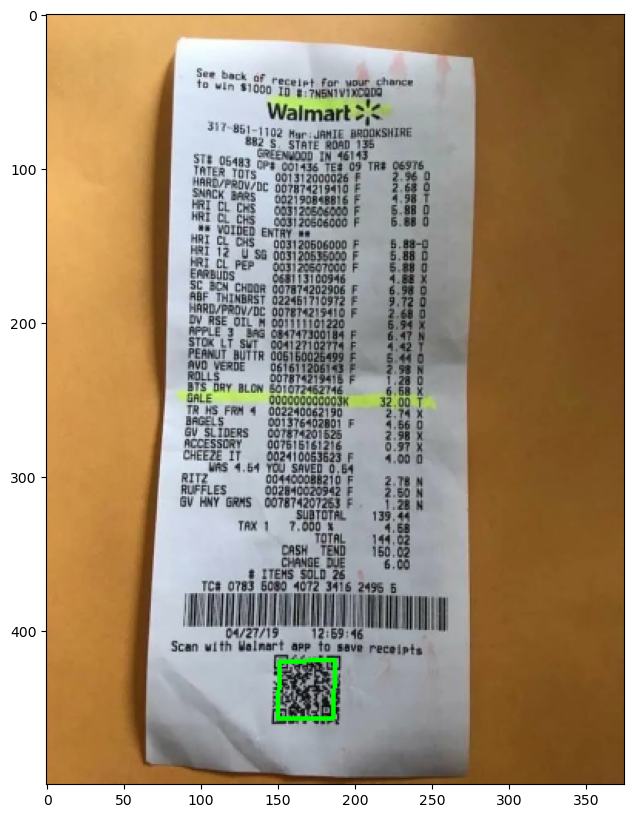

In [64]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

Great! We are done with locating a receipt!

# Step 2: Cropping and perspective restoration

We will make use of `cv2.warpPerspective` to restore perspective of the receipt. We have to do some preparations though:
* convert contour into a rectangle-like coordinate array consisting of clockwise ordered points: top-left, top-right, bottom-right, bottom-left
* use rectangle points to calculate destination points of the "scanned" view
* feed destination points into `cv2.getPerspectiveTransform` to calculate transformation matrix
* and finally use `cv2.warpPerspective` to restore the perspective!

Following helper methods are inspired by [Adrian Rosebrock blog](https://www.pyimagesearch.com/). You can find more details in the resources section.

In [65]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [66]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

Now we can make use of helper methods defined to get a perspective version of the receipt:

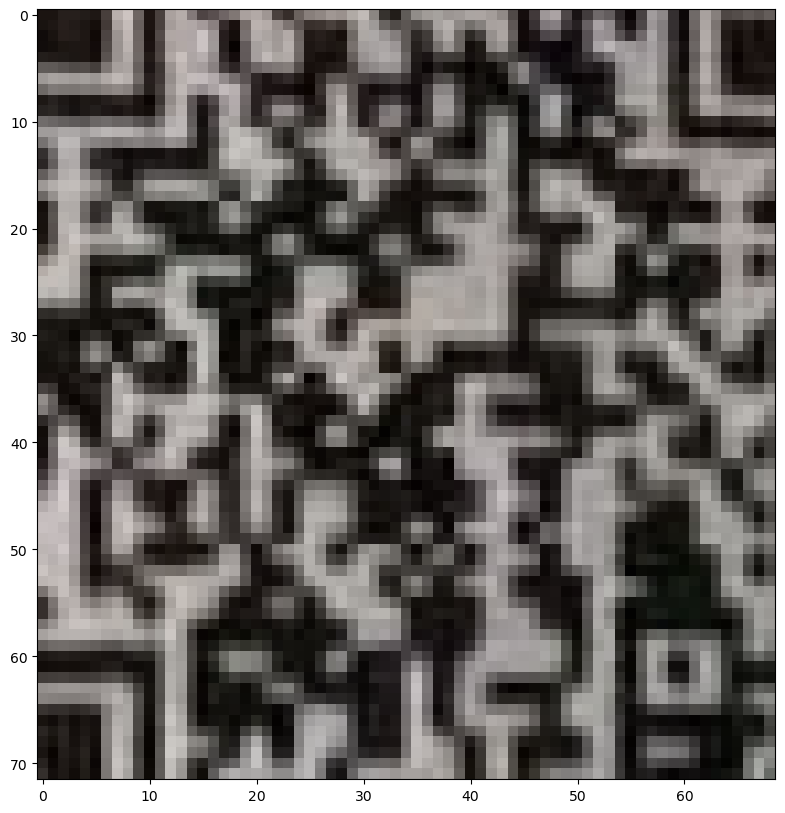

In [67]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

Now the final part - obtain black and white scanner effect with the color transformation:

In [68]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

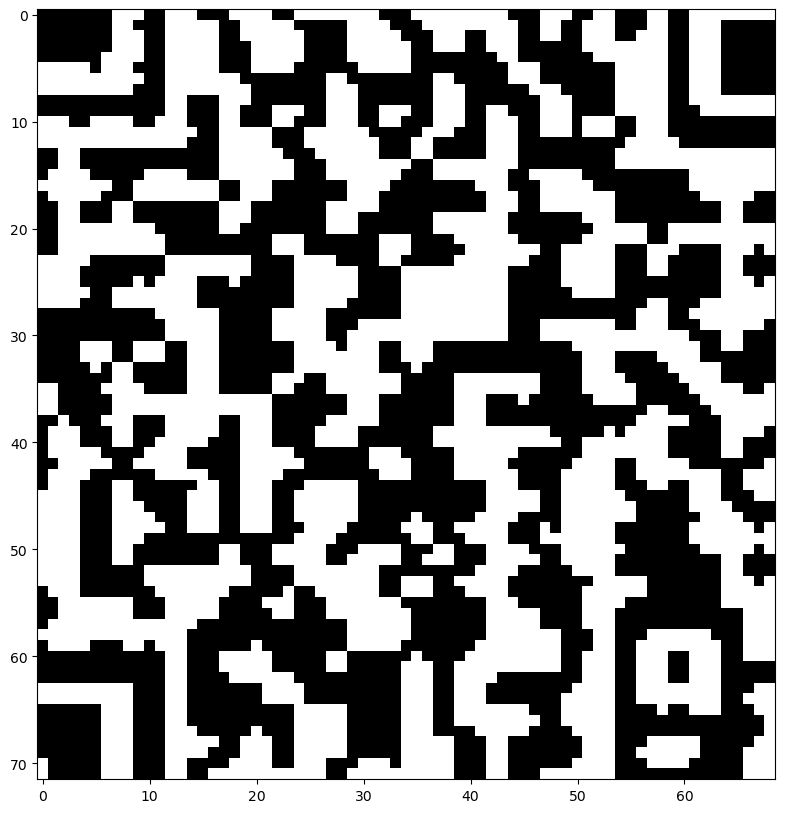

In [69]:
result = bw_scanner(scanned)
plot_gray(result)

In [70]:
output = Image.fromarray(result)
output.save('result.png')

We are done with the first part of the *Receipt OCR with OpenCV* series! 

Let's recap:
* At first, we have applied OpenCV preprocessing to get rid of noise and detect contours
* Next, we used heuristics and contour approximation methods to find contour of the receipt
* Finally, we used perspective transformation to obtain top-down view of the receipt

The transformed image is ready for Optical Character Recognition (OCR) which is covered in the [next notebook of the series](https://www.kaggle.com/dmitryyemelyanov/receipt-ocr-part-2-text-recognition-by-tesseract).

# About me

This notebook is published under the **Data Science DJ** initiative with the goal of giving you distilled pieces of valuable information, short and concise, easy to comprehend. 

I spend a few hours every day to write a single post about a single concept. You can find them by:

* [Joining my Telegram channel](https://t.me/datasciencedj)
* [Following my LinkedIn tag](https://www.linkedin.com/feed/hashtag/?keywords=datasciencedj)

If this work gives you joy, or maybe even inspiration, please consider contributing to my [Patreon account](https://www.patreon.com/datasciencedj).
Thank you!



# Resources
1. [How to Build a Kick-Ass Mobile Document Scanner in Just 5 Minutes](https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/) by Adrian Rosebrock
2. [Building a Pokedex in Python: OpenCV and Perspective Warping](https://www.pyimagesearch.com/2014/05/05/building-pokedex-python-opencv-perspective-warping-step-5-6/) by Adrian Rosebrock